In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV


from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [2]:
uploaded = files.upload()
df = pd.read_csv("video_game.csv")
df.head()

Saving video_game.csv to video_game.csv


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
df.shape

(16598, 11)

Separate X and y

In [ ]:
leakage_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

X = df.drop(columns=['Global_Sales'] + leakage_cols)
y = df['Global_Sales']

Numerical Column and Categorical Columns

In [ ]:
numeric_features = X.select_dtypes(include = ['int64','float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

# **Pipeline**

In [ ]:
# For numeric feature
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ]
)

For categorical feature

In [ ]:
cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [ ]:
# combinig columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Primary Model Selection

In [ ]:
# base learner
reg_lr = LinearRegression()
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [ ]:
# voting regressor
voting_reg = VotingRegressor(
    estimators=[
        ('lr', reg_lr),
        ('rf', reg_rf),
        ('gb', reg_gb)
    ]
)

In [ ]:
# stacking regressor
stacking_reg = StackingRegressor(
    estimators= [
        ('rf', reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator=Ridge()
)

# Model Training

In [ ]:
model_to_train = {
    'Linear Regression' : reg_lr,
    'Random Forest' : reg_rf,
    'Gradient Boosting': reg_gb,
    'Voting Ensemble ' : voting_reg,
    'Stacking Ensemble ' : stacking_reg
}

In [ ]:
result = []

for name, model in model_to_train.items():
  pipe = Pipeline(
      [
          ('preprocessor', preprocessor),
          ('model', model)
      ]
  )
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test,y_pred))
  mae = mean_absolute_error(y_test,y_pred)

  result.append({
      "Model": name,
      "R2 Score" :r2,
      "RMSE": rmse,
      "MAE" : mae
  })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)

print(results_df)

                Model  R2 Score      RMSE       MAE
4  Stacking Ensemble   0.870921  0.736415  0.023844
2   Gradient Boosting  0.858385  0.771348  0.021333
1       Random Forest  0.830349  0.844256  0.016452
3    Voting Ensemble   0.691119  1.139175  0.247575
0   Linear Regression -0.077157  2.127329  0.715140


In [ ]:
best_model_name = results_df.iloc[0]['Model']
best_model = model_to_train[best_model_name]

final_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', best_model)
    ]
)

final_pipe.fit(X_train, y_train)
y_final_pred = final_pipe.predict(X_test)

# Cross Validation

In [ ]:
final_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', stacking_reg)
    ]
)

In [ ]:
cv_score = cross_val_score(final_pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error",n_jobs = -1)
cv_rmse = np.sqrt(-cv_score)
cv_rmse

array([0.01687452, 0.06629999, 0.03028739, 0.04963749, 0.17326497])

In [ ]:
gb_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', reg_gb)
    ]
)

In [ ]:
cv_score_gb = cross_val_score(gb_pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error",n_jobs = -1)
cv_rmse_gb = np.sqrt(-cv_score_gb)
print("Gradient boosting cross val: ",cv_rmse_gb)

Gradient boosting cross val:  [0.02068789 0.07469407 0.04641288 0.05054736 0.18058918]


# Hyperparameter Tuning

In [ ]:
param_grid = {
    'model__rf__n_estimators': [100],
    'model__rf__max_depth': [None, 15],

    'model__gb__n_estimators': [100],
    'model__gb__learning_rate': [0.05, 0.1],

    'model__final_estimator__alpha': [1.0, 10.0]
}


In [ ]:
grid_search = GridSearchCV(
    estimator = final_pipe,
    param_grid = param_grid,
    cv = 5 ,
    scoring = 'neg_root_mean_squared_error',
    n_jobs =-1,
    verbose = 2
)

In [ ]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Rank', 'Year'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignor...
                                                                       RandomForestRegressor(random_state=42)),
                                                                      ('gb',
                                                                       GradientBoostingRegressor(random_state=42))],
                                                          final_estimator=Ridge()))]),
             n_jobs=-1,
             param_grid={'model__final_estimator__alpha': [1.0, 10.0],
                         'model__gb__learning_rate': [0.05, 0.1],
                         'model__gb__n_estimators': [100],
                         'model__rf__max_depth': [None, 15],
                         'model__rf__n_estimators': [100]},
             scoring='neg_root_mean_squared_error', verbose=2)

# Best Model Selection

In [ ]:
print(-grid_search.best_score_)

0.06350357017064776


In [ ]:
print(grid_search.best_params_)

{'model__final_estimator__alpha': 10.0, 'model__gb__learning_rate': 0.05, 'model__gb__n_estimators': 100, 'model__rf__max_depth': 15, 'model__rf__n_estimators': 100}


In [ ]:
final_model = grid_search.best_estimator_

# Model Performance Evaluation

In [ ]:
y_pred_final = final_model.predict(X_test)

# R2 Score
r2 = r2_score(y_test, y_pred_final)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

# MAE
mae = mean_absolute_error(y_test, y_pred_final)

# Print results
print("Model Evaluation on Test Set")
print("-" * 40)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print("-" * 40)

Model Evaluation on Test Set
----------------------------------------
R² Score: 0.8530
RMSE: 0.7859
MAE: 0.0191
----------------------------------------


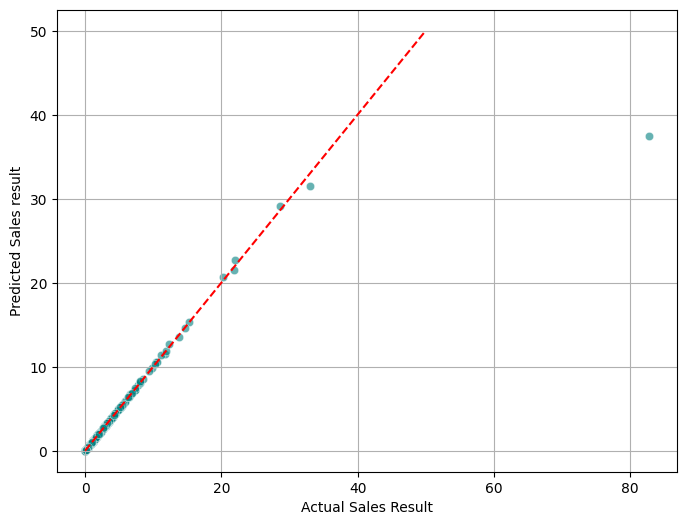

In [ ]:
#plot Actual vs predicted

plt.figure( figsize = (8,6) )

sns.scatterplot(x=y_test, y=y_pred_final, alpha = 0.6, color='teal' )
plt.plot( [0,50] , [0,50], color = "red", linestyle = '--'  )

plt.xlabel("Actual Sales Result")
plt.ylabel("Predicted Sales result")

plt.grid(True)
plt.show()

In [ ]:
with open( "video_game_predict_model.pkl", "wb" ) as file:
  pickle.dump( final_model, file )